# Statistical Models for Time Series

## Introduction

In this chapter, we study some linear statistical models for time series. These models are related to linear regression but account for the correlations that arise between data points in the same time series. The specific models we will discuss are:

* Autoregressive (AR) models, moving average (MA) models, and autoregressive integrated moving average (ARIMA) models

* Vector autoregression (VAR)

* Hierarchical models.

These models have traditionally been the workhorses of time series forecasting, and they continue to be applied in a wide range of situations, from academic research to industry modeling.

## Limitations of linear regression

A linear regression assumes you have independently and identically distributed (iid) data. In time series data, points near in time tend to be strongly correlated with one another. 

Ordinary least squares linear regression can be applied to time series data provided the following conditions hold:

* The time series has a linear response to its predictors.

* No input variable is constant over time or perfectly correlated with another input variable

* For each point in time, the expected value of the error, given all explanatory variables for all time periods is 0.

* The error at any given time period is uncorrelated with the inputs at any time period in the past or future. So a plot of the autocorrelation function of the errors will not indicate any pattern.

* Variance of the error is independent of time.

If these assumptions hold, then ordinary least squares regression is an unbiased estimator of the coefficients given the inputs, even for time series data.

## Autoregressive Models

The autoregressive (AR) model relies on the intuition that the past predicts the future and so posits a time series process in which the value at a point in time t is a function of the series’s values at earlier points in time.

Autoregression is a regression on past values to predict future values. The simplest AR model, an AR(1) model, describes a system as follows:

![](assets/AR1.png)

The generalization of this notation allows the present value of an AR process to depend on the p most recent values, producing an AR(p) process.

We now switch to more traditional notation, which uses ϕ to denote the autoregression coefficients:

![](assets/ARp.png)

An important condition to impose to the model is that if it stationary. __Weak stationarity__ requires only that the mean and variance of a process be time invariant.

__Strong stationarity__ requires that the distribution of the random variables output by a process remain the same over time.

When applying this condition to our model AR(1), we get (after some algebra that we skip):

![](assets/stationarity_mu.png)

![](assets/stationarity_sigma.png)

### Choosing parameters for an AR(p) model

To assess the appropriateness of an AR model for your data, begin by plotting the process and its partial autocorrelation function (PACF).The PACF of an AR process should cut off to zero beyond the order p of an AR(p) process, giving a concrete and visual indication of the order of an AR process empirically seen in the data.

On the other hand, an AR process will not have an informative autocorrelation function (ACF), although it will have the characteristic shape of an ACF: exponential tapering with increasing time offset.

Let’s take a look at this with some actual data. We use some demand forecasting data published in the UCI Machine Learning Repository.

Let's start by importing all libraries we will need and preparing a directory to store the plots:

In [3]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pmdarima as pm

from ast import Param
from random import seed
from sqlite3 import paramstyle
from numpy import disp
from pathlib import Path
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from pmdarima.arima import StepwiseContext

plt.style.use("seaborn-darkgrid")
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["xtick.labelsize"] = 12
matplotlib.rcParams["ytick.labelsize"] = 12
matplotlib.rcParams["text.color"] = "k"
matplotlib.rcParams["figure.dpi"] = 200

directory = "plots"
Path(directory).mkdir(parents=True, exist_ok=True)

out = "AIC: {0:0.3f}, HQIC: {1:0.3f}, BIC: {2:0.3f}"

df = pd.read_csv(".lesson/assets/Daily_Demand_Forecasting_Orders.csv", sep=";")
df.rename(
    columns={
        df.columns[0]: "week",
        df.columns[8]: "traffic",
        df.columns[10]: "banking_orders_2",
        df.columns[11]: "banking_orders_3",
    },
    inplace=True,
)

/tmp/ipykernel_5608/771585454.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")



First we plot the data in chronological order. Since we will model this as an AR process, we look to the PACF to set a cutoff on the order of the process.


[ 1.         -0.07683346 -0.15068941 -0.29648405 -0.00211414  0.08261929
 -0.19891212 -0.15551471 -0.02011504 -0.124374    0.25751968 -0.19883129
 -0.11337395 -0.02616629 -0.0796434  -0.04727785 -0.02890248 -0.07133566]


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


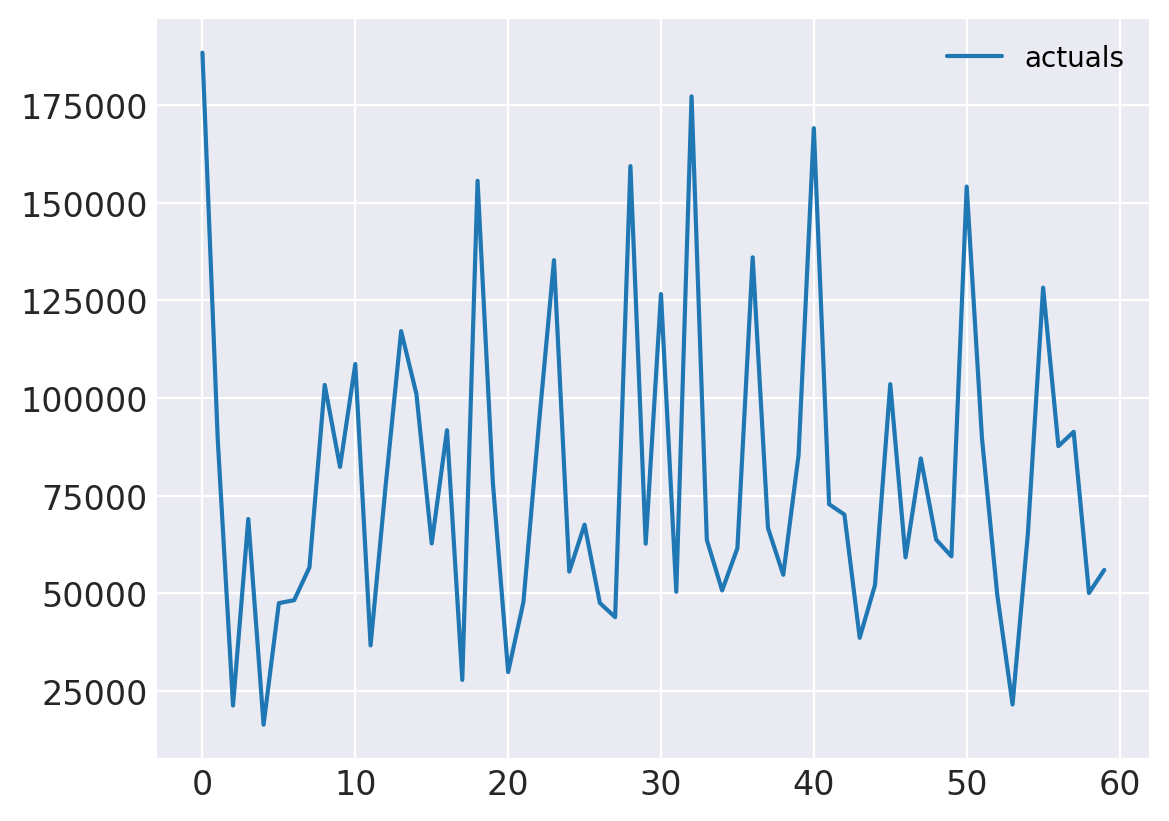

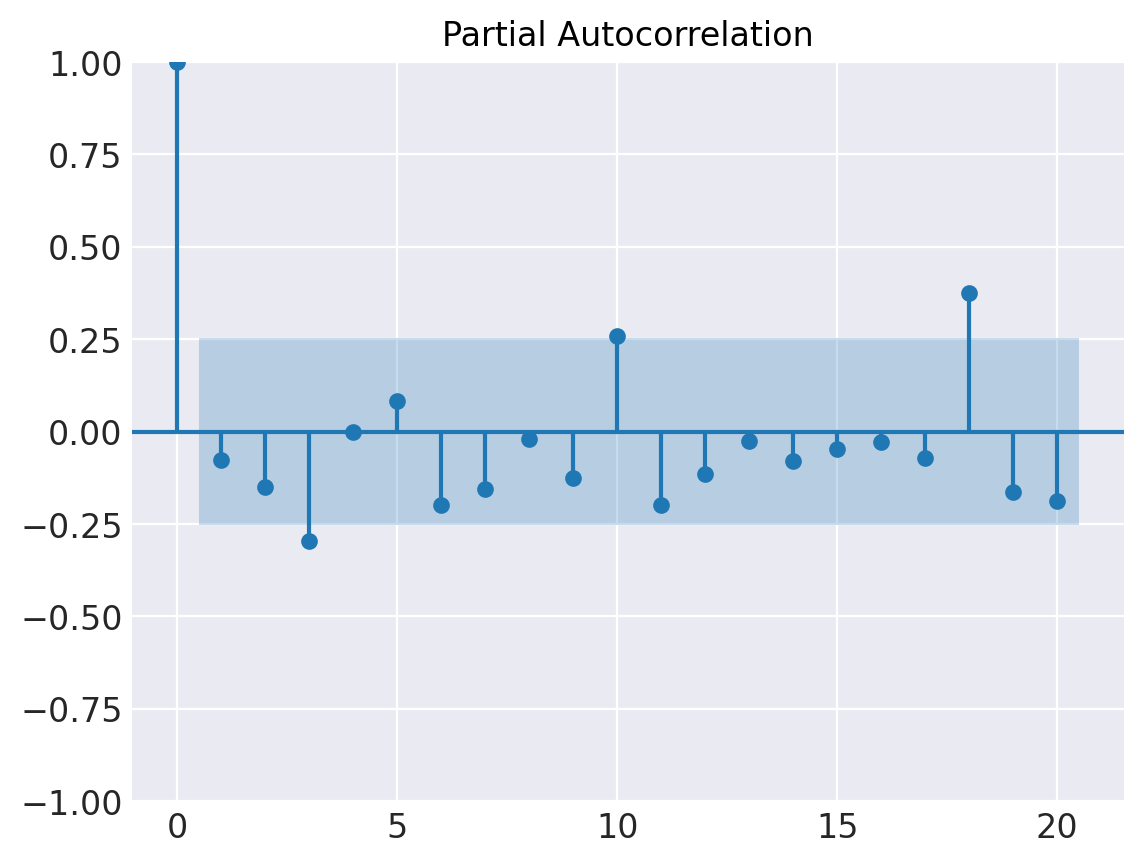

In [4]:
plt.plot(df.banking_orders_2, label="actuals")
plt.legend()
plt.savefig(directory + "/banking_orders_2")

plot_pacf(df.banking_orders_2, lags=20)
pacf_values = pacf(df.banking_orders_2)
plt.savefig(directory + "/pacf_banking_orders_2")
print(pacf_values)


We can see that the value of the PACF crosses the 5% significance threshold at lag 3. the order selected is determined (with the default parameters we left undisturbed) based on the Akaike information criterion (AIC).

This is helpful to know because it shows that the visual selection we made by examining the PACF is consistent with the selection that would be made by minimizing an information criterion.

In other words, we choose the lag equal to the value of the PACF that crosses the significance threshold, which is the one that yields the lowes AIC.


In [5]:
for lags in range(5):
    res = AutoReg(df.banking_orders_2, lags=lags, seasonal=False).fit()
    print(out.format(res.aic, res.hqic, res.bic))  # low AIC is good
    print(res.params)

AIC: 1446.364, HQIC: 1448.003, BIC: 1450.553
const    79401.483333
dtype: float64
AIC: 1417.065, HQIC: 1419.498, BIC: 1423.297
const                  83581.840670
banking_orders_2.L1       -0.075541
dtype: float64
AIC: 1394.326, HQIC: 1397.537, BIC: 1402.568
const                  98411.621730
banking_orders_2.L1       -0.115996
banking_orders_2.L2       -0.149721
dtype: float64
AIC: 1366.551, HQIC: 1370.521, BIC: 1376.766
const                  123217.551337
banking_orders_2.L1        -0.152903
banking_orders_2.L2        -0.129049
banking_orders_2.L3        -0.285619
dtype: float64
AIC: 1345.549, HQIC: 1350.260, BIC: 1357.701
const                  124229.443310
banking_orders_2.L1        -0.145109
banking_orders_2.L2        -0.132465
banking_orders_2.L3        -0.304616
banking_orders_2.L4        -0.001640
dtype: float64



The AIC of a model is equal to `AIC = 2k – 2lnL` where k is the number of parameters of the model and L is the maximum likelihood value for that function. 

In general, we want to lessen the complexity of the model (i.e., lessen k) while increasing the likelihood/goodness-of-fit of the model (i.e., L). So we will favor models with smaller AIC values over those with greater AIC values.

We may, however, want to limit the coefficients. For example, looking at the PACF, we might wonder whether we really want to include a coefficient for the lag – 1 term.


const     7.940148e+04
ar.L1    -1.514173e-01
ar.L2    -1.280665e-01
ar.L3    -2.858685e-01
sigma2    1.270266e+09
dtype: float64


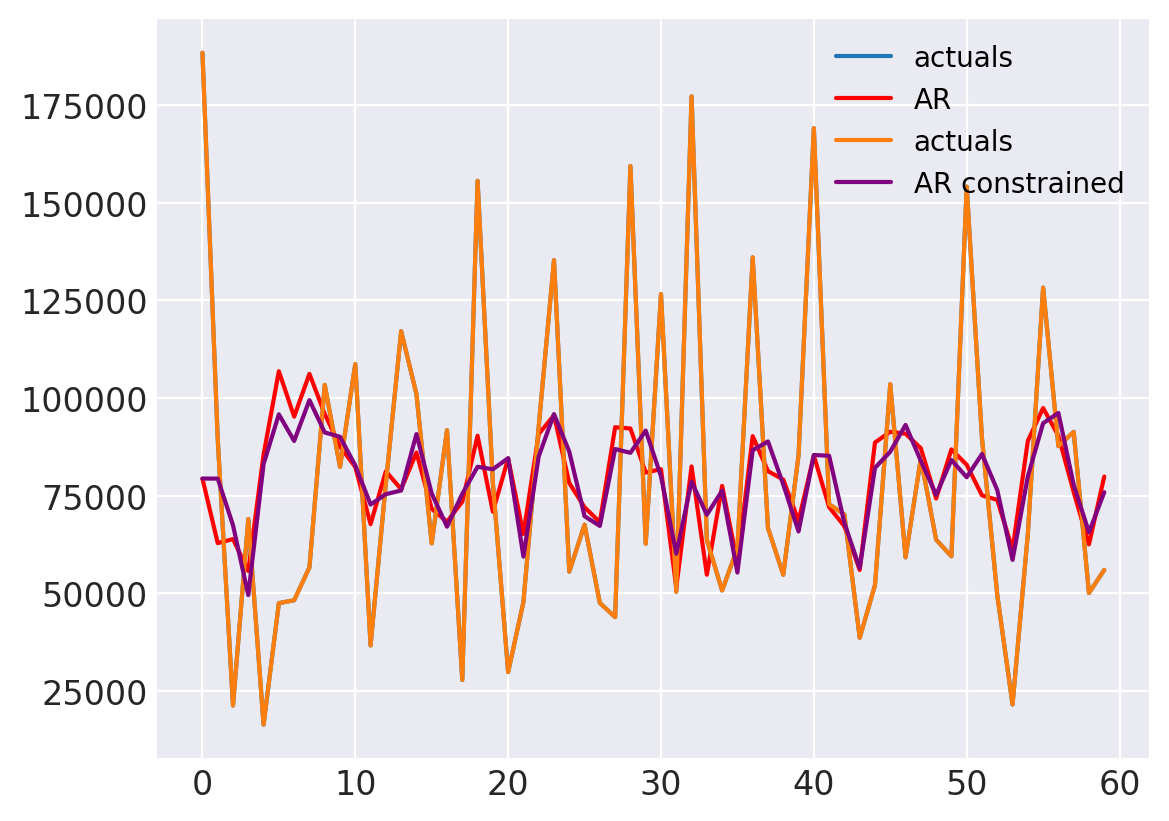

In [6]:
model = ARIMA(
    df.banking_orders_2, order=(3, 0, 0), enforce_stationarity=False
)  # if enforced, then we cannot constrain parameters
results = model.fit()
plt.plot(df.banking_orders_2, label="actuals")
plt.plot(results.fittedvalues, color="red", label="AR")
plt.legend()
plt.savefig(directory + "/AR_unconstrained")
print(results.params)

with model.fix_params({"ar.L1": 0}):
    results = model.fit()
    plt.plot(df.banking_orders_2, label="actuals")
    plt.plot(results.fittedvalues, color="purple", label="AR constrained")
    plt.legend()
    plt.savefig(directory + "/AR_constrained")


We now inspect our model performance on our training data by plotting the ACF of the residuals to see if there is a pattern of self-correlation that our model does not cover.


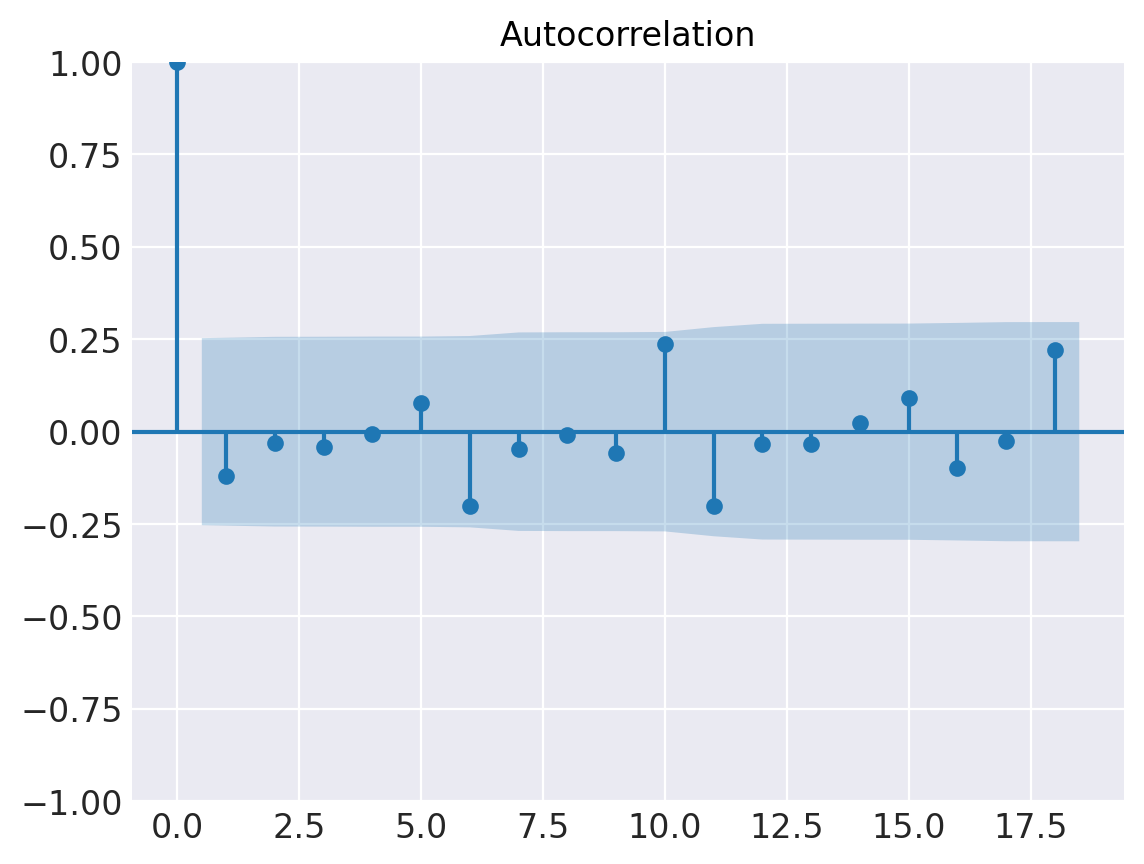

In [7]:
plot_acf(results.resid)
plt.savefig(directory + '/acf_residuals_AR_constrained')


We do not see a pattern of self-correlation here among the residuals.

Another test that is commonly performed is the __Ljung-Box__ test, an overall test of the randomness of a time series. More formally it poses the following null and alternate hypotheses:

* __H0__: The data does not exhibit serial correlation.

* __H1__: The data does exhibit serial correlation.

This test is commonly applied to AR (and more generally, ARIMA) models, and more specifically to the residuals from the model fit rather than to the model itself:


In [8]:
sm.stats.acorr_ljungbox(results.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,8.838425,0.547503



We apply the __Ljung-Box__ test to our est.1 model to assess its goodness of fit. We cannot reject the null hypothesis that the data does not exhibit serial correlation. This is confirmation of what we just found by plotting the ACF of the residuals.

### Forecasting with an AR(p) process

We first explore the case of one time step ahead and then discuss how predicting multiple steps ahead differs from the further case. 

From a coding perspective there is not much difference, although the underlying mathematics is more elaborate in the latter case.

We continue working with the model from the demand data, with the lag – 1 coefficient constrained to 0 (fit as est.1 earlier).


In [9]:
df.banking_orders_2.corr(results.fittedvalues)
print(results.forecast())  # one-step ahead
print(results.forecast(steps=2))

60    79457.407686
dtype: float64
60    79457.407686
61    89678.484693
Name: predicted_mean, dtype: float64



If we calculate the correlation between the predicted value and the actual value, we get 0.29. This is not bad in some contexts, but remember that sometimes differencing the data will remove what seemed like a strong relationship and replace it with one that is essentially random.

Let’s imagine that we wanted to produce a two-step-ahead forecast instead of a one-step-ahead forecast. What we would do is first produce the one-step-ahead forecast, and then use this to furnish the  value we need to predict.

We can use the ease of predicting many time steps into the future to generate many multi-step-ahead forecasts for different horizons.


plt.plot(df.banking_orders_2, color="blue", label="actuals")
plt.plot(
    pd.concat([results.fittedvalues, results.forecast(steps=30)]),
    color="red",
    label="AR forecast",
)
plt.legend()
plt.savefig(directory + "/AR_forecast")

plot_acf(df.banking_orders_2)



The main difference between the forecast and the data is that the forecast is less variable than the data. It may predict the direction of the future correctly, but not the scale of the change from one time period to another. This is not a problem per se but rather reflects the fact that forecasts are means of the predicted distributions and so necessarily will have lower variability than sampled data.

Another important observation is that the variance of the prediction decreases with increasing forward horizon. The reason for this is that the further forward in time we go, the less the actual data matters. One way of putting this is that forecasts further out in time converge to being the unconditional prediction.

## Moving Average Models

### The model

A moving average model can be expressed similarly to an autoregressive model except that the terms included in the linear equation refer to present and past error terms rather than present and past values of the process itself. So an MA model of order q is expressed as:


![](assets/MA.png)

MA models are by definition weakly stationary without the need to impose any constraints on their parameters. This is because the mean and variance of an MA process are both finite and invariant with time because the error terms are assumed to be iid with mean 0.

### Selecting parameters for an MA(q) process

We fit an MA model to the same data used fit to AR model, and we can use the ACF to determine the order of the MA process.

Unlike an autoregressive process, which has a slowly decaying ACF, the definition of the MA process ensures a sharp cutoff of the ACF for any value greater than q, the order of the MA process. 

This is because an autoregressive process depends on previous terms, whereas an MA model, incorporating the impulses directly through their value, has a mechanism to stop the impulse propagation from progressing indefinitely.


const     7.940148e+04
ma.L1    -2.310277e-01
ma.L2     9.762910e-02
ma.L3    -3.254323e-01
ma.L4     5.470727e-01
ma.L5    -2.617525e-01
ma.L6    -5.272691e-01
ma.L7    -9.654563e-02
ma.L8    -9.611654e-02
ma.L9     4.363529e-01
sigma2    9.329790e+08
dtype: float64


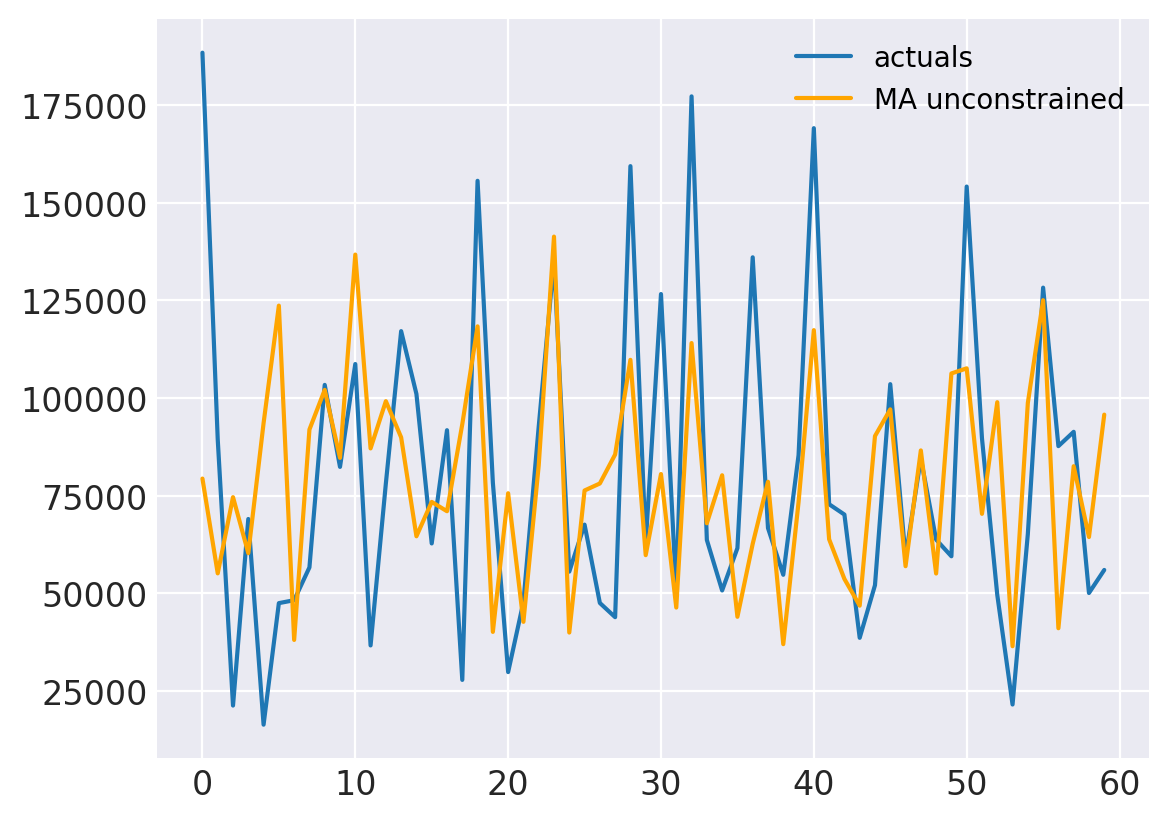

In [10]:
model = ARIMA(
    df.banking_orders_2, order=(0, 0, 9), enforce_invertibility=False
)  # invertibility prevents constraining parameters later on
results = model.fit()
plt.plot(df.banking_orders_2, label="actuals")
plt.plot(results.fittedvalues, color="orange", label="MA unconstrained")
plt.legend()
plt.savefig(directory + "/MA_unconstrained")
print(results.params)

We see significant values at lags 3 and 9, so we fit an MA model with these lags.

const     7.940148e+04
ma.L1     0.000000e+00
ma.L2     0.000000e+00
ma.L3    -4.837804e-01
ma.L4     0.000000e+00
ma.L5     0.000000e+00
ma.L6     0.000000e+00
ma.L7     0.000000e+00
ma.L8     0.000000e+00
ma.L9    -9.348930e-03
sigma2    9.329790e+08
dtype: float64


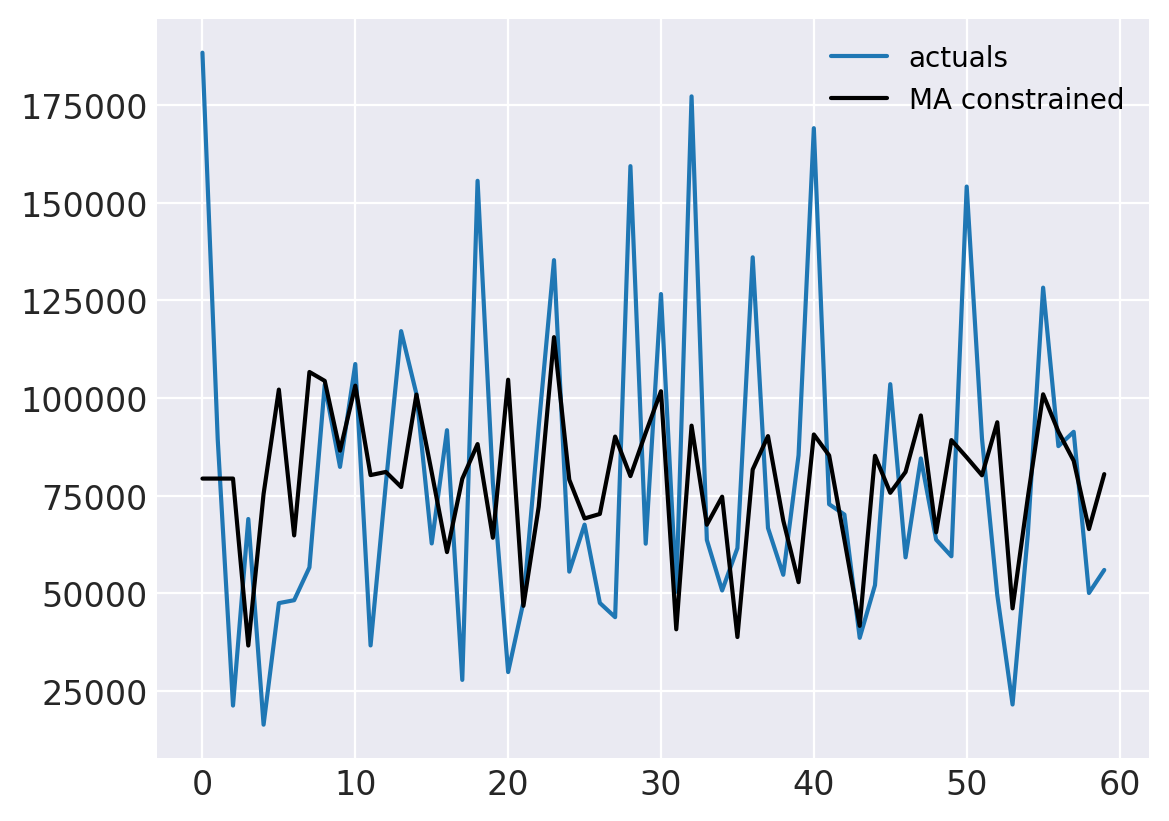

In [12]:
with model.fix_params(
    {"ma.L1": 0, "ma.L2": 0, "ma.L4": 0, "ma.L5": 0, "ma.L6": 0, "ma.L7": 0, "ma.L8": 0}
):
    results = model.fit()
    plt.plot(df.banking_orders_2, label="actuals")
    plt.plot(results.fittedvalues, color="black", label="MA constrained")
    plt.legend()
    plt.savefig(directory + "/MA_constrained")
    print(results.params)


### Forecasting an MA(q) process

MA models exhibit strong mean reversion and so forecasts rapidly converge to the mean of the process. This makes sense given that the process is considered to be a function of white noise.

If you forecast beyond the range of the model established by its order, the forecast will necessarily be the mean of the process by definition of the process.


60    75724.997073
dtype: float64
60    75724.997073
61    87730.643593
Name: predicted_mean, dtype: float64
60    75724.997073
61    87730.643593
62    91498.396735
63    79489.050327
64    79146.314641
65    79436.091043
66    79332.145105
67    79554.461946
68    79630.806954
69    79401.483339
70    79401.483339
71    79401.483339
72    79401.483339
73    79401.483339
74    79401.483339
75    79401.483339
76    79401.483339
77    79401.483339
78    79401.483339
79    79401.483339
Name: predicted_mean, dtype: float64


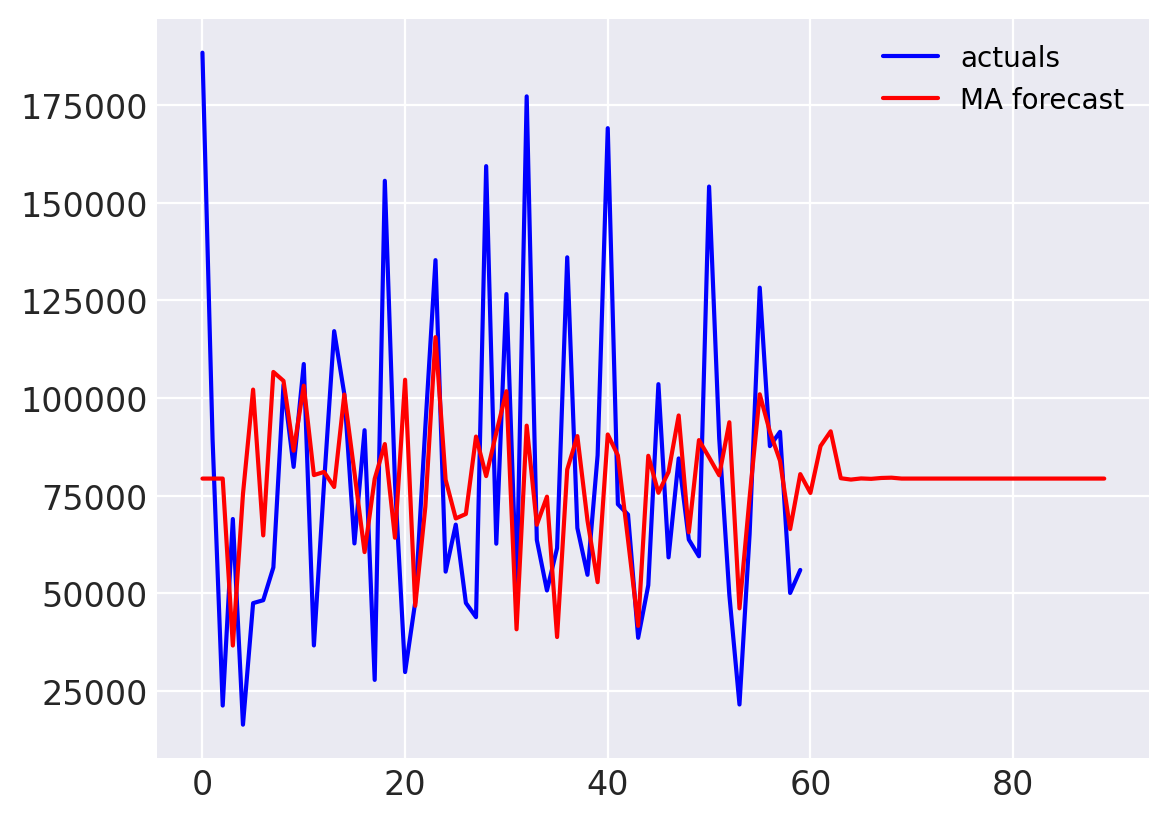

In [13]:
print(results.forecast())  # one-step ahead
print(results.forecast(steps=2))
print(
    results.forecast(steps=20)
)  # note how the pedictions only last 10 steps because our model is order 9

plt.plot(df.banking_orders_2, color="blue", label="actuals")
plt.plot(
    pd.concat([results.fittedvalues, results.forecast(steps=30)]),
    color="red",
    label="MA forecast",
)
plt.legend()
plt.savefig(directory + "/MA_forecast")


### Autoregressive Integrated Moving Average Models

Now we that we have examined AR and MA models individually, we look to the __Autoregressive Integrated Moving Average (ARIMA)__ model, which combines these, recognizing that the same time series can have both underlying AR and MA model dynamics. This alone would lead us to an ARMA model, but we extend to the ARIMA model, which accounts for differencing, a way of removing trends and rendering a time series stationary.

ARIMA models continue to deliver near state-of-the-art performance, particularly in cases of small data sets where more sophisticated machine learning or deep learning models are not at their best.

We have not investigated in depth whether either of our previous models is a particularly good fit, but it does seem clear from the fitting process we used that there are defensible arguments to describing the data with either an AR or an MA model. This raises the question: might it not be helpful to incorporate both behaviors into the same model?

The following table can be a handy way of examining a time series process to see whether an AR, MA, or ARMA description of the process is best.

| Kind of plot | AR(p) | MA(q) | ARMA |
|--------------|-------|-------|------|
| ACF behavior | Falls off slowly | Sharp drop after lag = q | No sharp cutoff |
| PACF behavior | Sharp drop after lag = p | Falls off slowly | No sharp cutoff |

This brings us to an autoregressive moving average (ARMA) model, which is applied in the case that neither AR nor MA terms alone sufficiently describe the empirical dynamics. This is a likely case when diagnostics for AR and MA order statistics (PACF and ACF, respectively) point to nonzero values, indicating a term of a given order for either an AR or an MA term. These can be combined with an ARMA model.

![](assets/arma.png)

__Wold's theorem__ tells us that every covariance-stationary time series can be written as the sum of two time series, one deterministic and one stochastic. Based on this theorem, we can also say that a stationary process can be reasonably approximated by an ARMA model.

From an ARMA model, it is a simple transition to an __ARIMA__ model. The difference between an ARMA model and an ARIMA model is that the ARIMA model includes the term integrated, which refers to how many times the modeled time series must be differenced to produce stationarity.

The order of differencing should not be too great. In general, the value of each parameter of an __ARIMA(p, d, q)__ model should be kept as small as possible to avoid unwarranted complexity and overfitting to the sample data. As a not-at-all-universal rule of thumb, you should be quite __skeptical of values of d over 2 and values of p and q over 5__.

### Selecting parameters

The ARIMA model is specified in terms of the parameters `(p, d, q)`. We select the values of p, d, and q that are appropriate given the data we have.

Here are some well-known particular cases:

* ARIMA(0, 0, 0) is a white noise model.

* ARIMA(0, 1, 0) is a random walk, and ARIMA(0, 1, 0) with a nonzero constant is a random walk with drift.

* ARIMA(0, 1, 1) is an exponential smoothing model, and an ARIMA(0, 2, 2) is the same as Holt’s linear method, which extends exponential smoothing to data with a trend, so that it can be used to forecast data with an underlying trend.

We choose the order of our model based on a combination of domain knowledge, various fitting evaluation metrics (such as the AIC), and general knowledge of how the PACF and ACF should appear for a given underlying process (as described in Table 6-1). 

Next we will demonstrate fitting an ARIMA model to a process using both a manual iterative process based on the PACF and ACF and also based on an automated parameter selection tool via the `pmdarima` package’s auto.arima() function.

### Manually fitting a model

There are heuristics for choosing the parameters of an ARIMA model, where parsimony is paramount. One popular and longstanding method is the __Box-Jenkins__ method, which is an iterative multistep process:

* Use your data, visualizations, and underlying knowledge to select a class of model appropriate to your data.

* Estimate the parameters given your training data.

* Evaluate the performance of your model based on your training data and tweak the parameters.

Let’s work through one example of fitting data. First, we generate some data from an ARMA process:


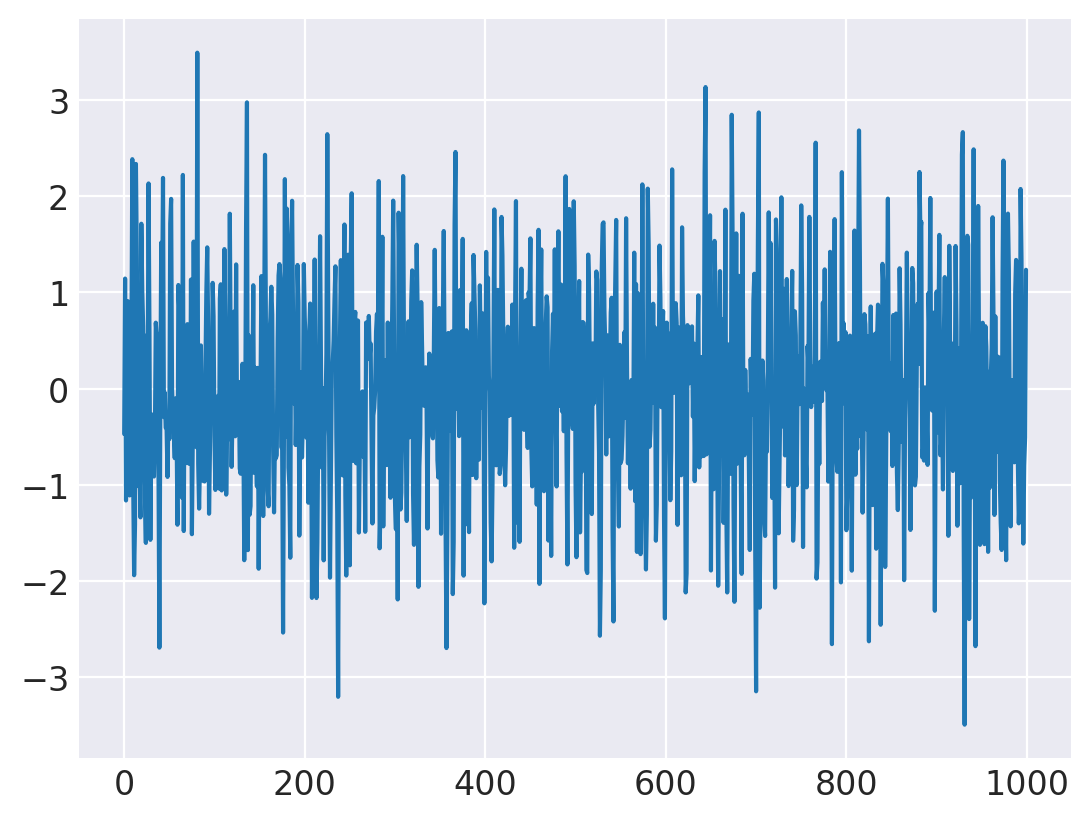

In [14]:
s = 1234
np.random.seed(s)

arparams = np.array([-1, 0.8, -0.4])  # Beware of the -1
maparams = np.array([1, -0.7])  # Beware of the 1
n = 1000
y = sm.tsa.arma_generate_sample(nsample=n, ar=arparams, ma=maparams)
plt.plot(y)


Then we examine the ACF and PACF of `y`:


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


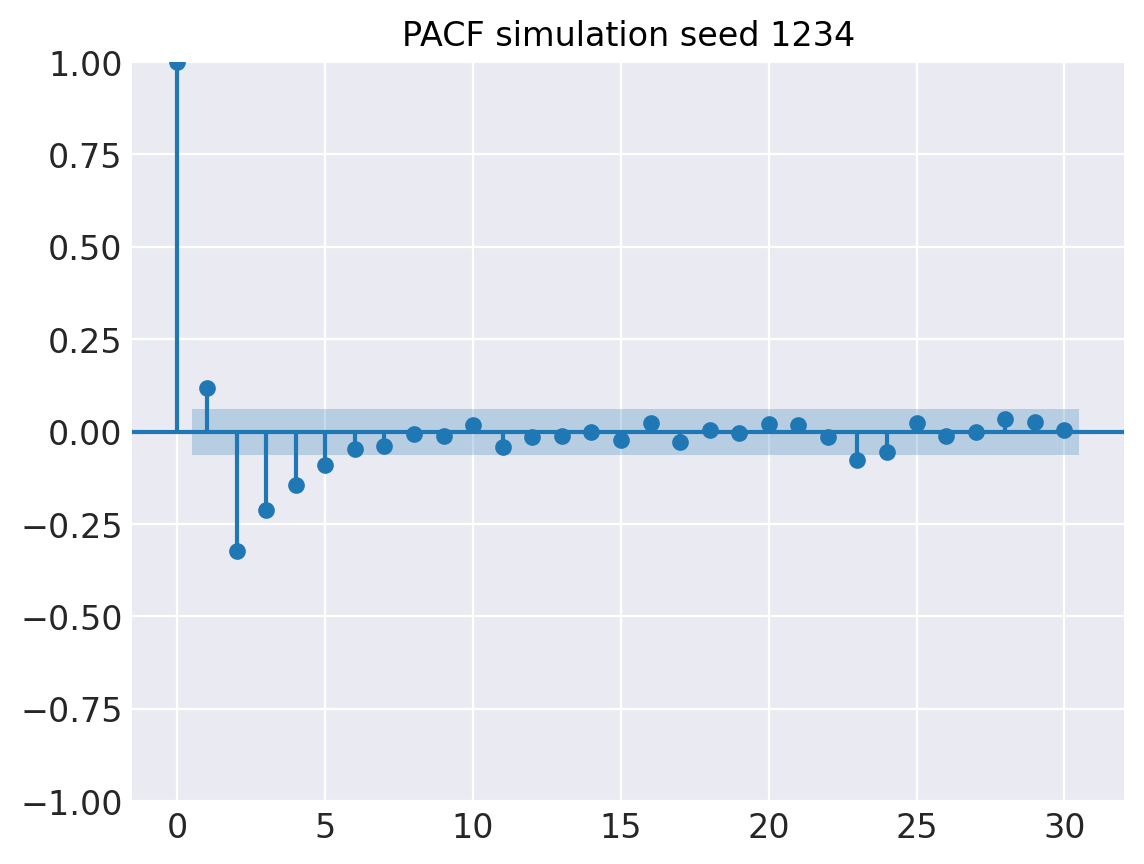

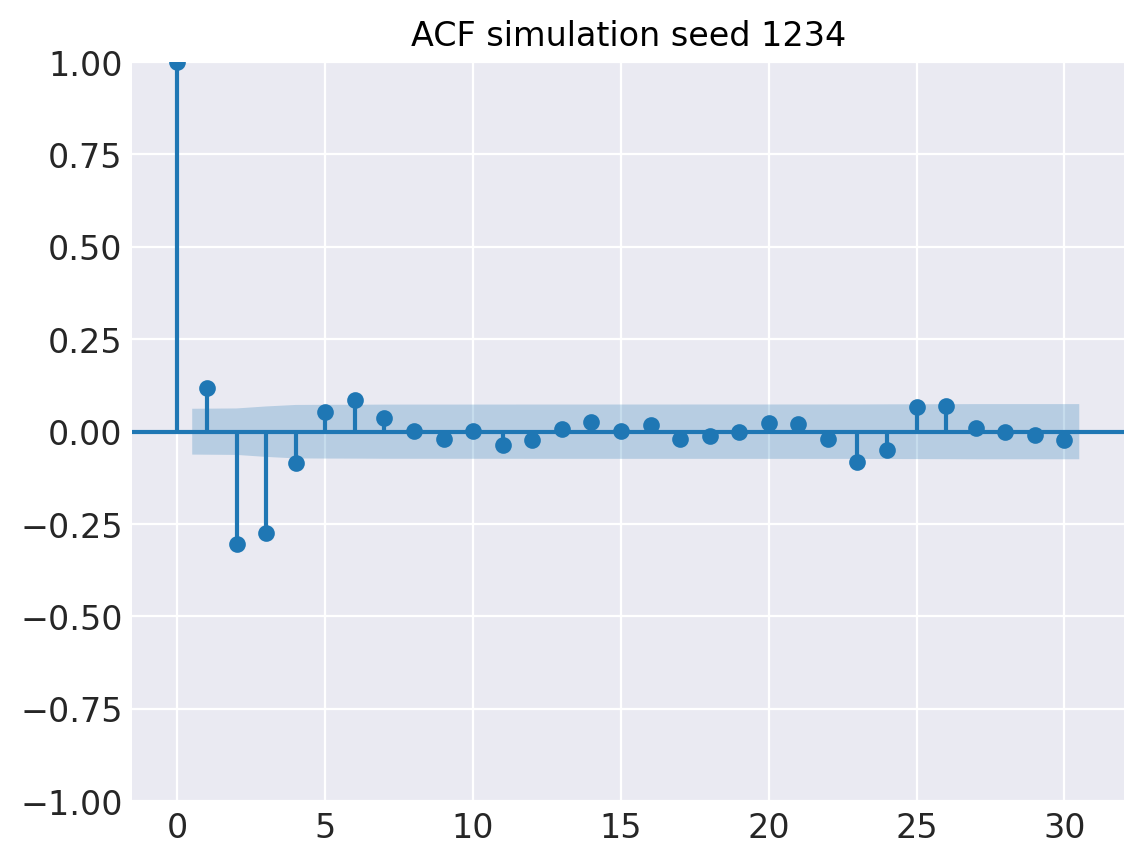

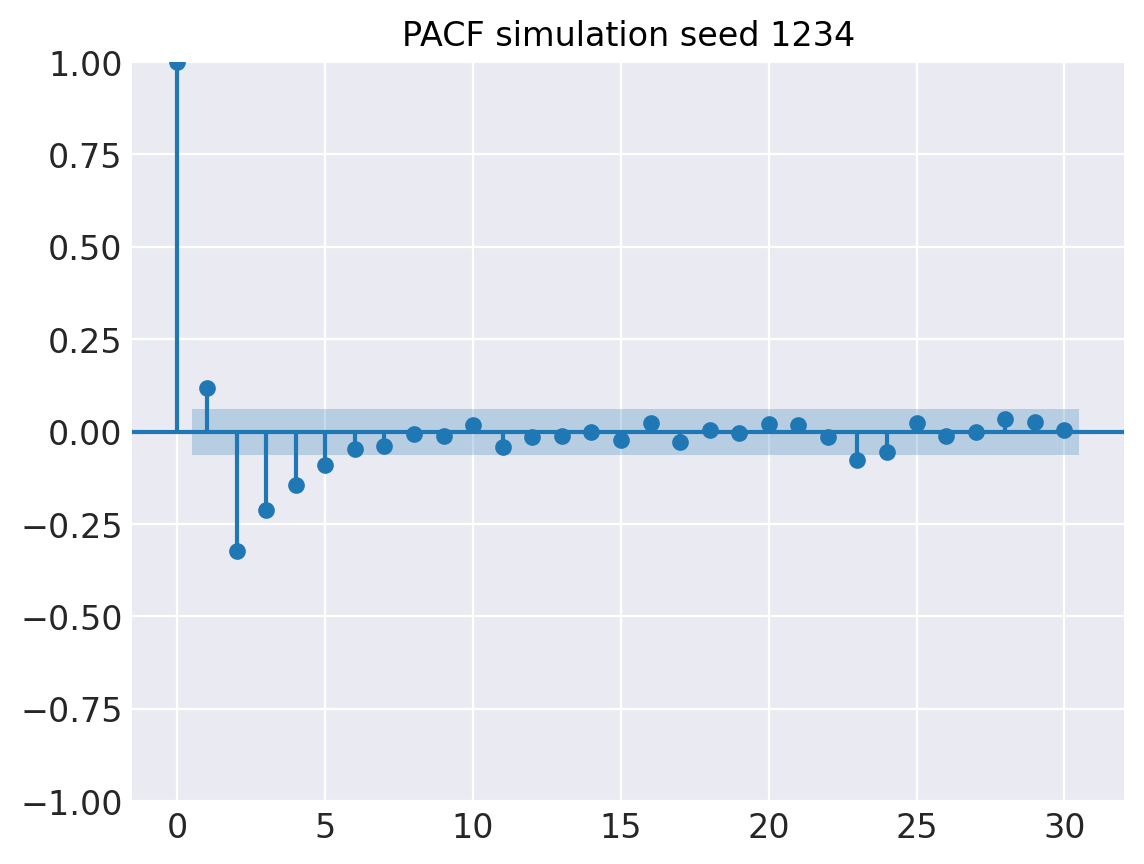

In [15]:
plot_acf(y, title=f"ACF simulation seed {s}")
plot_pacf(y, title=f"PACF simulation seed {s}")


We can see that neither the ACF nor the PACF appears to have a sharp cutoff, suggesting that this is an ARMA process.

We will try with two models, a `(1,0,1)` and a `(2,0,1)`, and compare their performance:


(1, 0, 1)
Correlation coefficient : 0.21052024331777264
['const', 'ar.L1', 'ma.L1', 'sigma2']
[-0.00807888 -0.33213961  0.5354835   1.10196581]


<Figure size 1280x960 with 0 Axes>

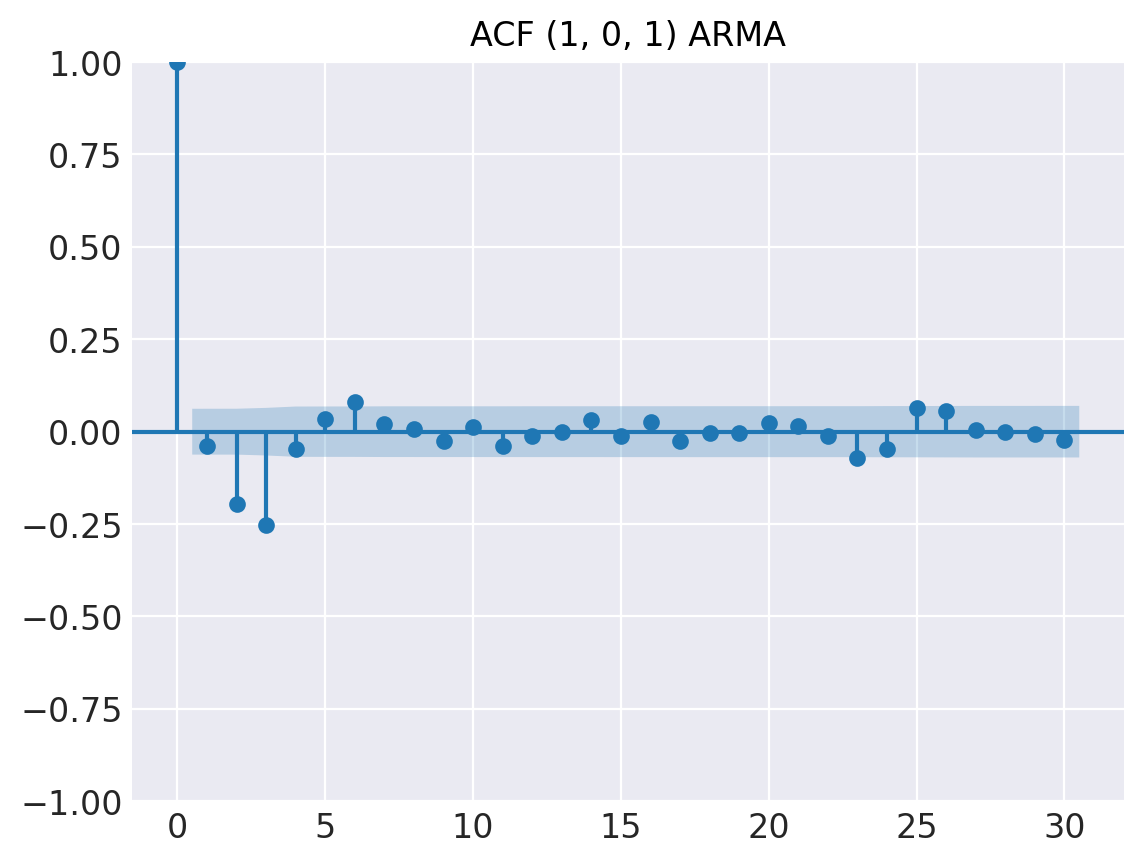

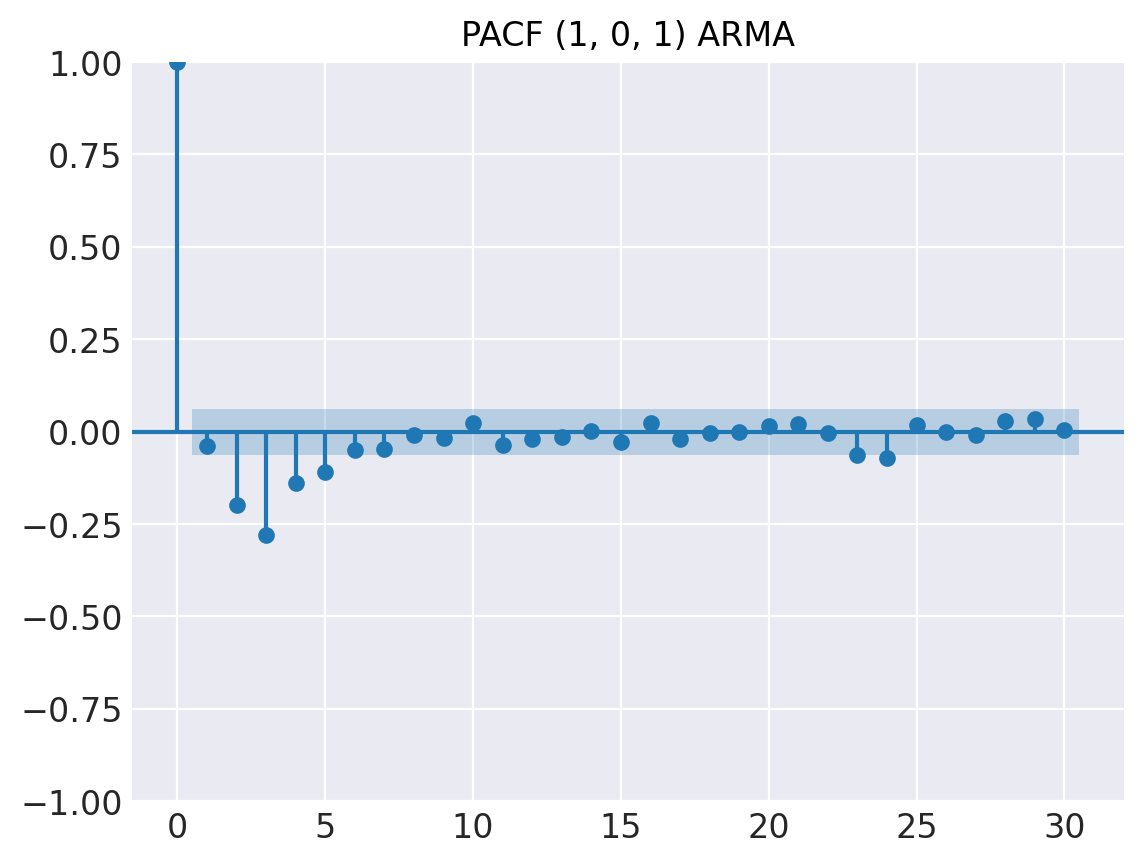

(2, 0, 1)
Correlation coefficient : 0.4280635551274748
['const', 'ar.L1', 'ar.L2', 'ma.L1', 'sigma2']
[-0.00796798  0.71268555 -0.39486524 -0.66818563  0.94134619]


<Figure size 1280x960 with 0 Axes>

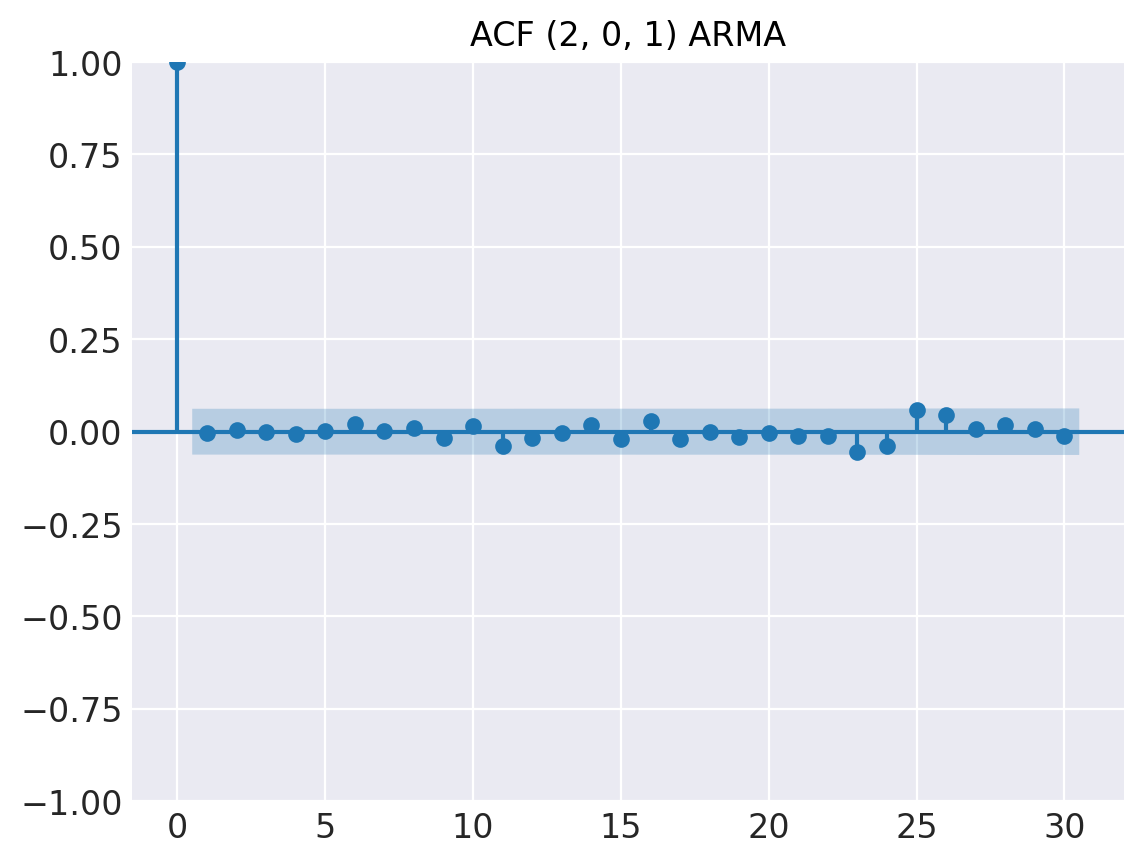

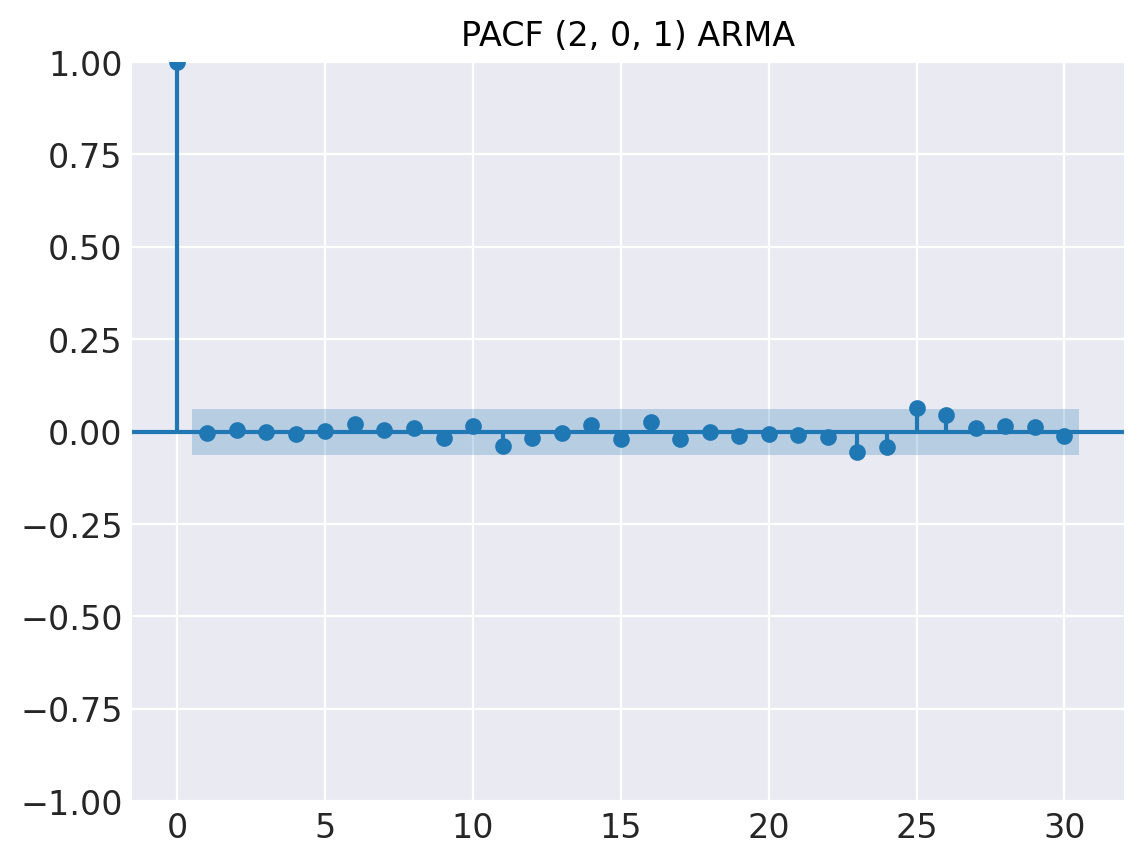

In [16]:
for k in [(1, 0, 1), (2, 0, 1)]:
    print(f"{k}")
    model = ARIMA(y, order=k, enforce_invertibility=False)
    results = model.fit()
    plt.plot(y, label="simulation")
    plt.plot(results.fittedvalues, color="orange", label="ARMA unconstrained")
    plt.title(f"{k} ARMA")
    plt.legend()
    plt.savefig(f"{directory}/simulation_ARMA_unconstrained_{k}")
    print(f"Correlation coefficient : {np.corrcoef(y, results.fittedvalues)[0,1]}")
    plt.clf()
    print(results.param_names)
    print(results.params)
    plot_acf(results.resid, title=f"ACF {k} ARMA")
    plot_pacf(results.resid, title=f"PACF {k} ARMA")
    plt.show()


The residuals of `(1,0,1)` show particularly PACF values, suggesting that we have not fully described the autoregressive behavior.

The residuals of `(2,0,1)` no longer show large values for either the ACF or the PACF. Given our desire for a parsimonious model and the dangers of overfitting an ARIMA model, a wise analyst would likely stop here, not seeing any further behavior in the residuals that needs to be fit via an autoregressive, moving average, or differencing component.

Another quick way to compare the models that has been included in the code is through the correlation coefficient. We also see a substantial improvement transitioning from `ARIMA(1,0,1)` to `ARIMA(2,0,1)`.

Over decades, practitioners have developed good rules of thumb for identifying problems such as when there are too many terms of a certain kind, when a model has been overdifferenced, when the pattern in residuals points to certain problems, and so on.

There are some legitimate criticisms of fitting an ARIMA process “by hand.” Fitting by hand can be a somewhat poorly specified process and puts a lot of pressure on the analyst’s discretion, and can be time-consuming and path-dependent as to the ultimate outcome.

### Using automated model fitting

Nowadays we can get away from a manually iterative fitting process in favor of an automated model selection in some cases. Our model selection can be driven according to various information loss criteria, such as the AIC, via the `auto_arima` function in the `pmdarima` package:


In [17]:
with StepwiseContext(max_dur=15):
    model = pm.auto_arima(
        df.banking_orders_2, stepwise=True, error_action="ignore", seasonal=True
    )

results = model.fit(y)
print(f"results.summary()")

results.summary()



If you are going to make `auto_arima` or a similar automated model selection tool, it’s important to read the documentation, experiment with synthetic data, and also read about other analysts’ experiences. There are some known scenarios where the function will not perform as naively expected, and there are also known workarounds.

We have demonstrated two distinct ways of estimating parameters: either by following a __Box-Jenkins__ approach to fitting the model or using an __automated fit__ from the forecast package. In fact, practitioners have very strong opinions on this, with some fiercely advocating only in favor of manual iteration and others equally fiercely in favor of automated selection tools.

### Vector Autoregression

In the real world, we are often lucky enough to have several time series in parallel that are presumably related to one another. We can generate an AR(p) model to the case of multiple variables. The beauty of such a model is that it provides for the fact that variables both influence one another and are in turn influenced — that is, there is no privileged `y`.

You can write a VAR in a very similar manner to an AR:

![](assets/var.png)

Even for a simple case, the number of parameters in the model grows very quickly like `N + p*N**2`. Hence, we should not throw in time series gratuitously simply because we have the data but instead reserve this method for when we really expect a relationship.

VAR models are most often used in econometrics. They sometimes come under fire because they do not have any structure beyond the hypothesis that all values influence one another. It is precisely for this reason that the model’s goodness of fit can be difficult to assess.

Here’s a quick demonstration. Let’s look at the underlying UCI demand information and consider using a second column to predict `Banking orders (2)` rather than just its own data.

To determine what parameters to use, we use the `VAR` function from `statsmodels`.


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 26, Feb, 2023
Time:                     18:01:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    40.3338
Nobs:                     56.0000    HQIC:                   39.9352
Log likelihood:          -1252.04    FPE:                1.72373e+17
AIC:                      39.6828    Det(Omega_mle):     1.27944e+17
--------------------------------------------------------------------
Results for equation banking_orders_2
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                  109805.646213     27012.523645            4.065           0.000
L1.banking_orders_2        -0.234623         0.145610           -1.611           0.107
L1.banking_orders_3      

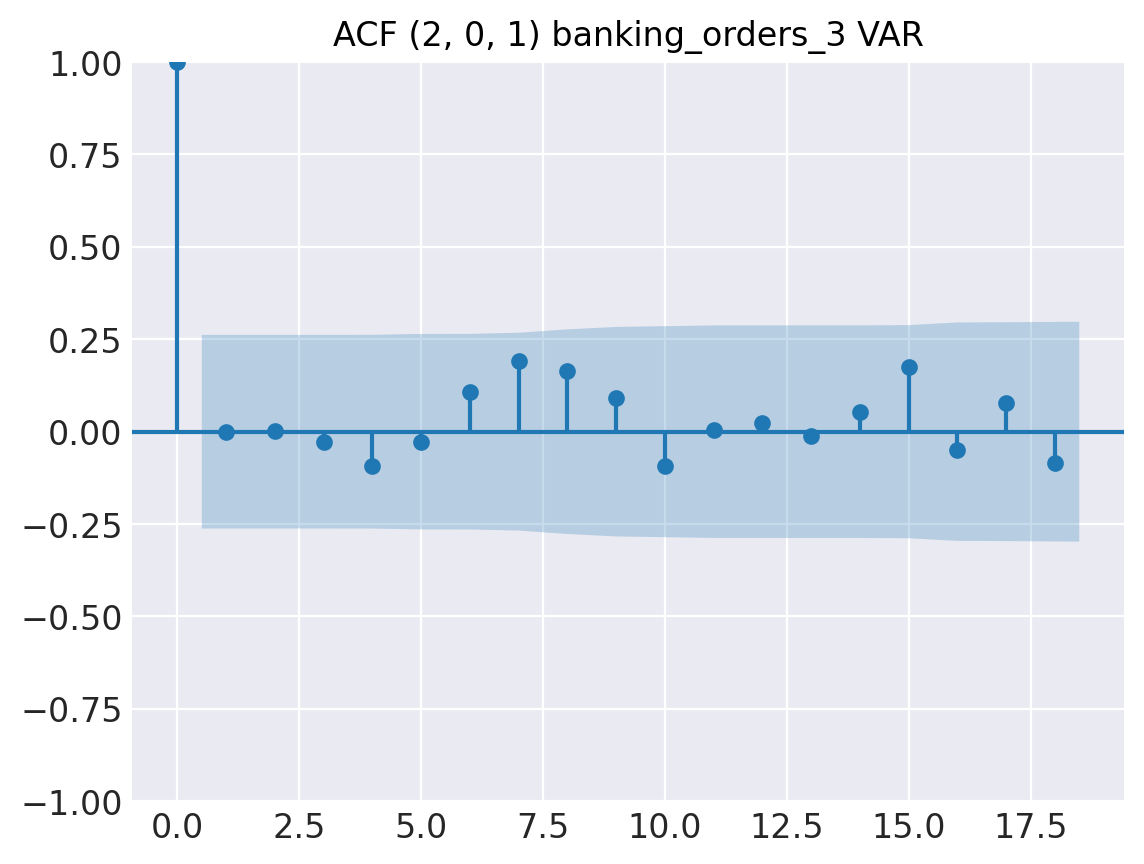

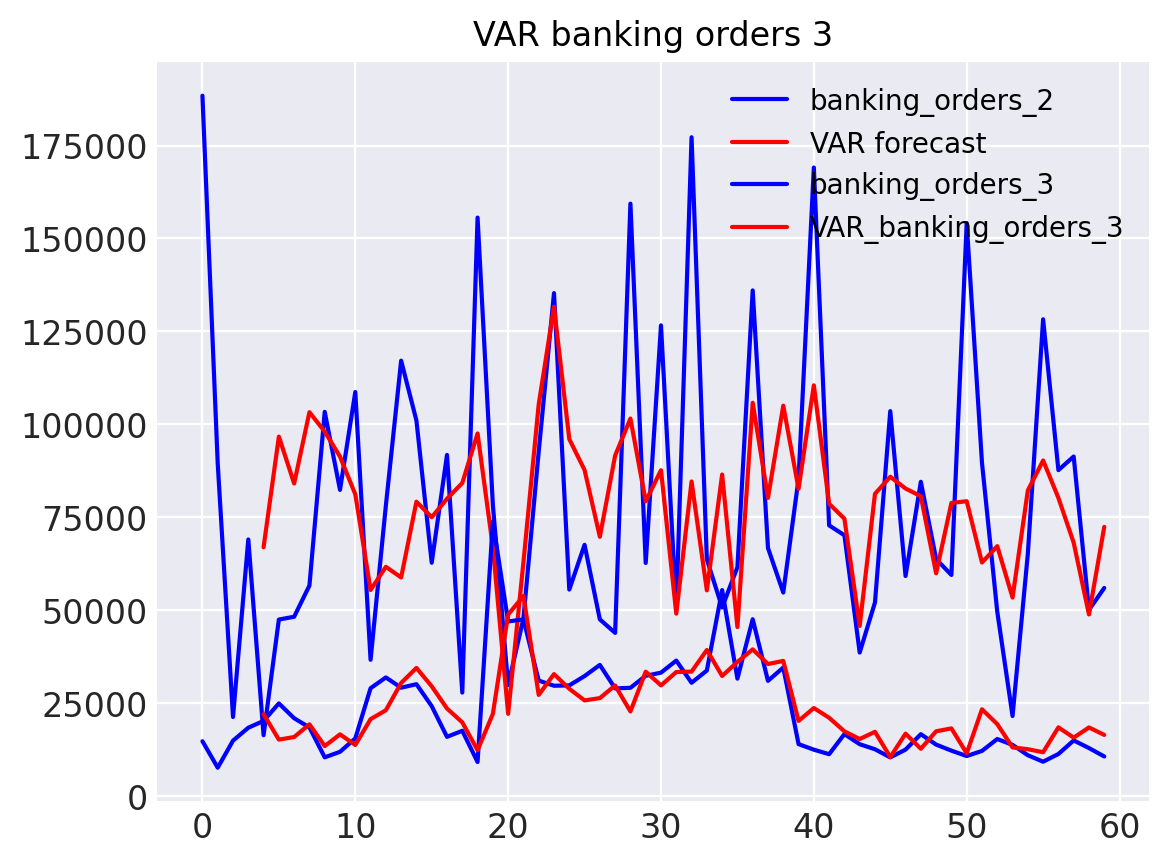

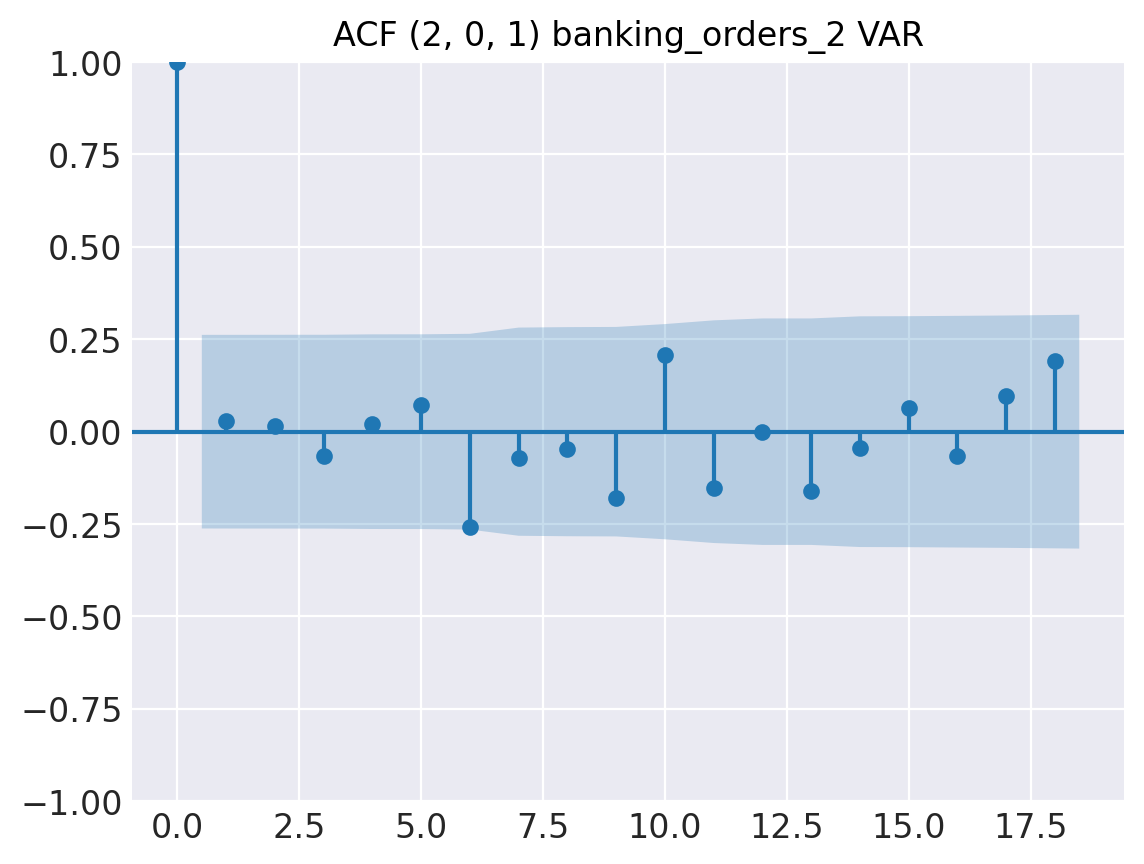

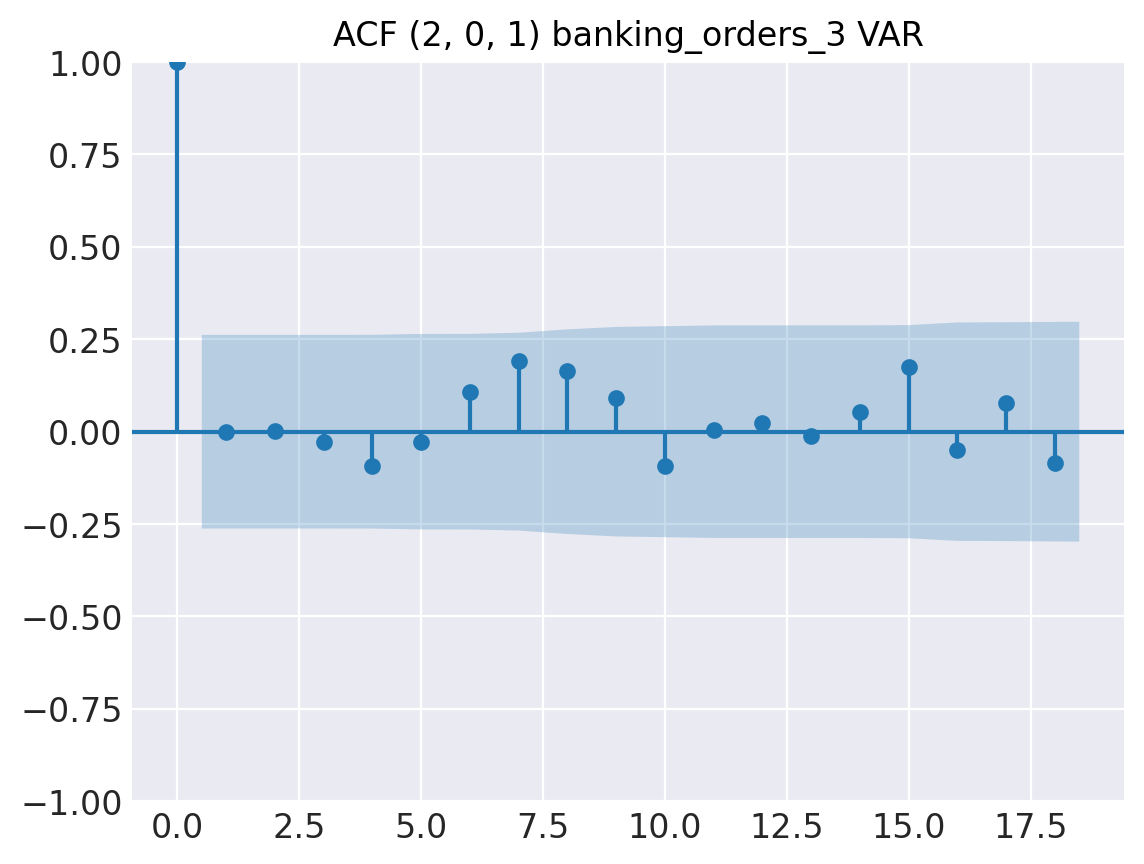

In [18]:
model = VAR(df[["banking_orders_2", "banking_orders_3"]])
results = model.fit(4)  # lag order is chosen based on information criterion
print(results.summary())

plt.plot(df.banking_orders_2, color="blue", label="banking_orders_2")
plt.plot(
    pd.concat([results.fittedvalues.banking_orders_2]),
    color="red",
    label="VAR forecast",
)
plt.legend()
plt.title("VAR_banking_orders_2")
plt.savefig(directory + "/VAR_forecast_banking_2")

plt.plot(df.banking_orders_3, color="blue", label="banking_orders_3")
plt.plot(
    pd.concat([results.fittedvalues.banking_orders_3]),
    color="red",
    label="VAR_banking_orders_3",
)
plt.legend()
plt.title("VAR banking orders 3")
plt.savefig(directory + "/VAR_forecast_traffic_3")

plot_acf(results.resid.banking_orders_2, title=f"ACF {k} banking_orders_2 VAR")
plot_acf(results.resid.banking_orders_3, title=f"ACF {k} banking_orders_3 VAR")


Although the ACF is not as clearly supportive of no autocorrelation in the residuals as we might like, and one of the forecasts is "slow" in changing relative to the real data, in general the model does an acceptable job.

Given that for univariate models we examined a variety of models, leading up to the ARMA and ARIMA versions, you may wonder whether there is a __VARIMA__ model. There is indeed, but it is not used very much given that VAR performs relatively well and is already quite complicated. In practice for industrial and academic use cases, you will overwhelmingly see the use of VAR rather than VARIMA.


## Variations on Statistical Models

### Seasonal ARIMA

A Seasonal ARIMA (SARIMA) model assumes multiplicative seasonality. For this reason, a SARIMA model can be expressed as ARIMA (p, d, q) × (P, D, Q)m. The model postulates that the seasonal behavior itself can be thought of as an ARIMA process, with m specifying the number of time steps per seasonal cycle.

### ARCH, GARCH

ARCH stands for “Autoregressive Conditional Heteroskedasticity.” This model is used almost exclusively in the finance industry. It is often covered in time series courses, so it is worth mentioning here. This class of models is based on the observation that stock prices do not have constant variance, and that in fact the variance itself seems autoregressive conditional on the earlier variances.

### Hierarchical time series models

Hierarchical time series arise in situations like these:

* Total monthly demand for a company’s products, which can then be broken down by SKU number

* Weekly political polling data for the electorate as a whole, and then that same polling data broken down by demographics

* Total count of tourists landing in the EU daily versus counts of tourists landing in each member nation in particular

Forecasts can be generated with a number of different methodologies that have historically been available with this package:

* Generate the lowest-level forecasts (the most individualized) and aggregate these up to produce the higher-level forecasts.

* Generate the highest-level forecasts and then generate lower-level forecasts based on the historical proportions of each component of the aggregate.

* It is possible to try to obtain the best of each methodology by choosing a “middle” approach where a mid-level forecast is generated (assuming you have several layers of hierarchy).